In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

In [3]:
fn_random_start = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn_random_start)


In [14]:
data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mutation_log = grouped[numerical_cols].apply(


In [15]:
# Mutation stats

good_cols = list(data.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(data, 'binding_rates_dissociation') + get_true_interaction_cols(data, 'eqconstants') +
get_true_interaction_cols(data, 'energies') + get_true_interaction_cols(data, 'binding_sites') + num_group_cols + num_bs_cols]
dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)

/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:125: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  if k != 'binding_sites':
/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:127: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mutation_log, k), var_name=f'{k}_idx'

# Mutation positions

In [16]:
data_e = data.explode('mutation_positions')


<AxesSubplot: xlabel='mutation_positions', ylabel='fold_change_ratio_from_mutation_to_base'>

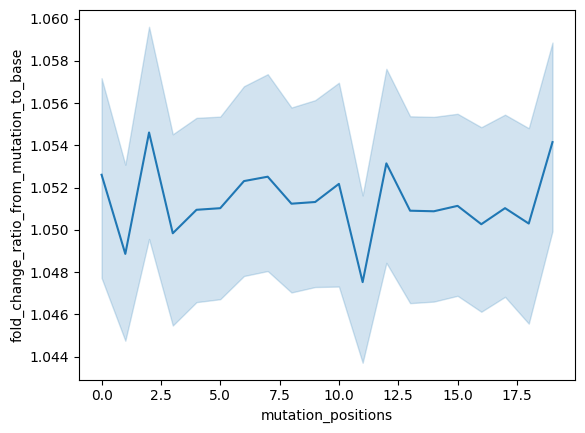

In [17]:
sns.lineplot(data_e.reset_index(), x='mutation_positions', y='fold_change_ratio_from_mutation_to_base')
plt.title('Fold change ratio (mutation / reference)\nper mutation position')
plt.ylabel('Fold change ratio')


Text(0, 0.5, 'Fold change ratio')

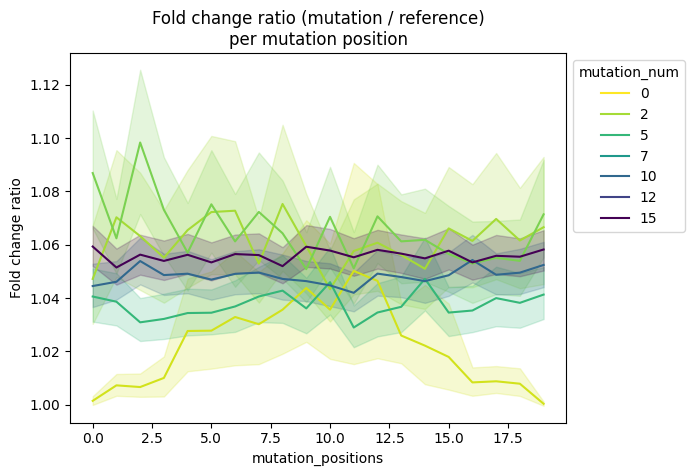

In [36]:
ax = sns.lineplot(data_e.reset_index(), x='mutation_positions', y='fold_change_ratio_from_mutation_to_base', hue='mutation_num', palette='viridis_r')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Fold change ratio (mutation / reference)\nper mutation position')
plt.ylabel('Fold change ratio')


Text(0, 0.5, 'Fold change ratio')

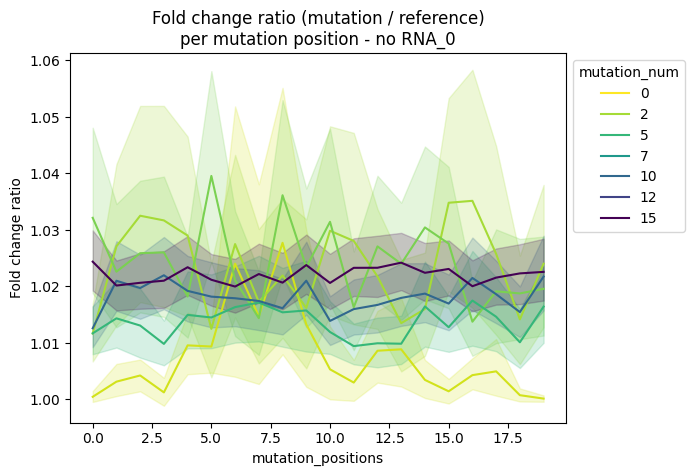

In [37]:

ax = sns.lineplot(data_e[data_e['sample_name'] != 'RNA_0'].reset_index(), x='mutation_positions', y='fold_change_ratio_from_mutation_to_base', hue='mutation_num', palette='viridis_r')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Fold change ratio (mutation / reference)\nper mutation position - no RNA_0')
plt.ylabel('Fold change ratio')

In [20]:
[c for c in data_e.columns if 'amount' in c]

['max_amount',
 'min_amount',
 'max_amount_diff_to_base_circuit',
 'min_amount_diff_to_base_circuit',
 'max_amount_ratio_from_mutation_to_base',
 'min_amount_ratio_from_mutation_to_base',
 'max_amount_logm',
 'min_amount_logm',
 'max_amount_diff_to_base_circuit_logm',
 'min_amount_diff_to_base_circuit_logm',
 'max_amount_ratio_from_mutation_to_base_logm',
 'min_amount_ratio_from_mutation_to_base_logm']

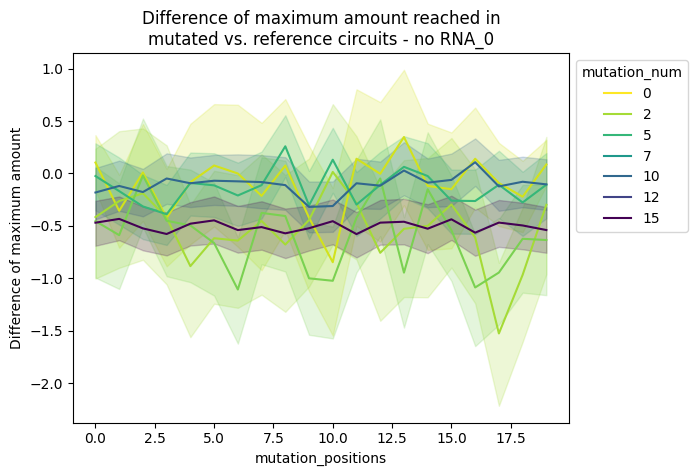

In [38]:
ax = sns.lineplot(data_e[data_e['sample_name'] != 'RNA_0'].reset_index(), x='mutation_positions', y='max_amount_diff_to_base_circuit', hue='mutation_num', palette='viridis_r')
plt.title('Difference of maximum amount reached in\nmutated vs. reference circuits - no RNA_0')
plt.ylabel('Difference of maximum amount')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Text(0.5, 0, 'Difference of maximum amount')

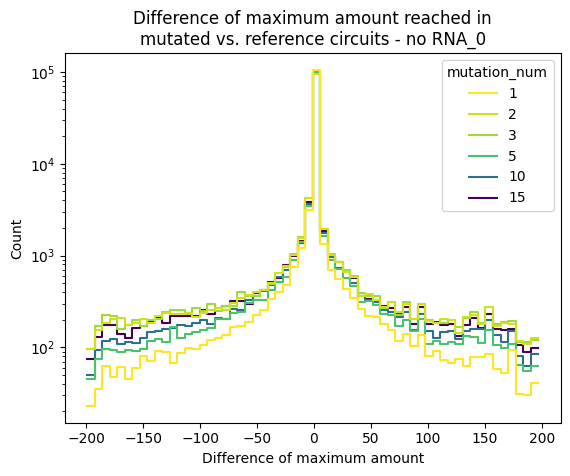

In [32]:
sns.histplot(data[(data['mutation_num'] > 0) &(data['sample_name'] != 'RNA_0')].reset_index(), x='max_amount_diff_to_base_circuit', hue='mutation_num', palette='viridis_r', element='step', log_scale=[False, True], fill=False, bins=60)
plt.title('Difference of maximum amount reached in\nmutated vs. reference circuits - no RNA_0')
plt.xlabel('Difference of maximum amount')


Text(0.5, 0, 'Difference of maximum amount')

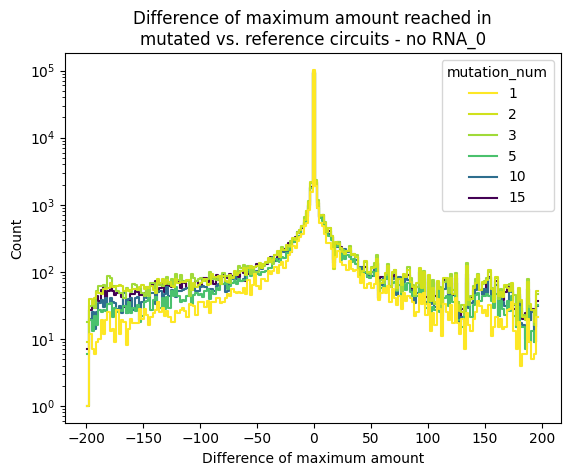

In [31]:
sns.histplot(data[(data['mutation_num'] > 0) &(data['sample_name'] != 'RNA_0')].reset_index(), x='max_amount_diff_to_base_circuit', hue='mutation_num', palette='viridis_r', element='step', log_scale=[False, True], fill=False, bins=200)
plt.title('Difference of maximum amount reached in\nmutated vs. reference circuits - no RNA_0')
plt.xlabel('Difference of maximum amount')